In [15]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [18]:
data_file = "../../dataset/filterd1.csv"

In [19]:
df = pd.read_csv(data_file)

In [ ]:
df.shape

In [ ]:
df.head()

In [3]:
import tensorflow as tf

from tensorflow import keras


In [19]:
batch_size = 16
data_batches = tf.data.experimental.make_csv_dataset(
    data_file, batch_size=batch_size,
    label_name="Score",
    select_columns=["Score","Summary"])

In [20]:
for feature_batch, label_batch in data_batches.take(1):
  print("'Score': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))


'Score': [5 5 5 5 5 5 4 5 4 5 5 5 5 5 5 4]
features:
  'Summary'           : [b'a good buy' b"I'm buying two!" b'Wife loves the stuff' b'Stunned'
 b'Flavorful and Natural Garrotxa Goat Cheese'
 b'Best canned fruit I have ever eatten' b'On sale' b'good eating'
 b'Firm quality chip' b'Convenient and tasty too!' b'Awesome!!!'
 b'Great raw diet food for on the go!' b'Best  peanut butter made'
 b'Great color' b'Awesome' b'Light Coconut Flavored Coffee.']


In [44]:
a = "ss"
for feature_batch, label_batch in data_batches.take(1):
    for key, value in feature_batch.items():
        # print(value)
        a = value

a.numpy()[1]

b'what quantity is it!'

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


In [21]:
sentences = []
labels = []

with open(data_file, 'r', encoding = "utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[6])
        sentence = row[8]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
        sentences.append(sentence)

In [22]:
vocab_size = 1000
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [32]:
len(sentences)

64862

In [33]:
# train_size = int(len(sentences) * training_portion)
train_size = 14*16*16*16

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

57344
57344
57344
7518
7518


In [34]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

8
50
3
50
2
50


In [35]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

7518
(7518, 50)


In [36]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[1]
[1]
[1]
(57344, 1)
[1]
[1]
[1]
(7518, 1)


In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            10304     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 150       
Total params: 77,038
Trainable params: 77,038
Non-trainable params: 0
_________________________________________________________________


In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [39]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, steps_per_epoch = 64, callbacks = [callback])

Train on 57344 samples, validate on 7518 samples
Epoch 1/30
57344/57344 - 31s - loss: 1.2949 - accuracy: 0.5976 - val_loss: 1.1659 - val_accuracy: 0.6198
Epoch 2/30
57344/57344 - 28s - loss: 1.1867 - accuracy: 0.6054 - val_loss: 1.1630 - val_accuracy: 0.6198
Epoch 3/30
57344/57344 - 27s - loss: 1.1852 - accuracy: 0.6054 - val_loss: 1.1628 - val_accuracy: 0.6198
Epoch 4/30
57344/57344 - 26s - loss: 1.1847 - accuracy: 0.6054 - val_loss: 1.1618 - val_accuracy: 0.6198
Epoch 5/30
57344/57344 - 26s - loss: 1.1844 - accuracy: 0.6054 - val_loss: 1.1623 - val_accuracy: 0.6198


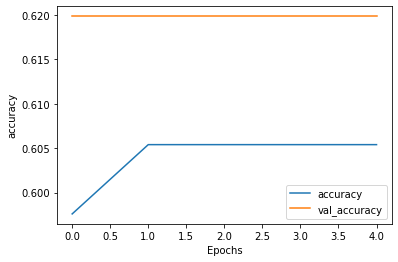

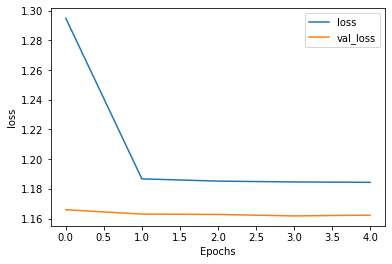

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 102       
Total params: 17,174
Trainable params: 17,174
Non-trainable params: 0
_________________________________________________________________
Train on 57344 samples, validate on 7518 samples
Epoch 1/30
57344/57344 - 7s - loss: 1.1875 - accuracy: 0.6054 - val

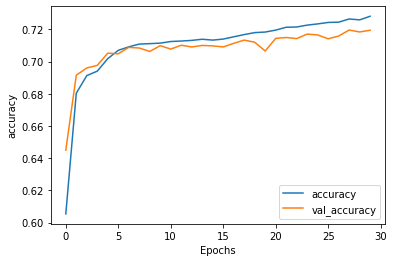

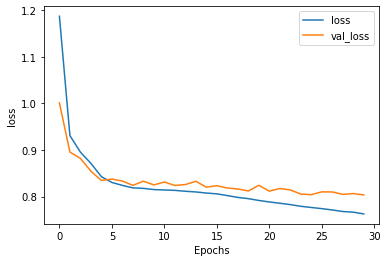

In [50]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # tf.keras.layers.LSTM(64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, steps_per_epoch = 64*16, callbacks=[callback])

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 198       
Total params: 22,054
Trainable params: 22,054
Non-trainable params: 0
_________________________________________________________________
Train on 57344 samples, validate on 7518 samples
Epoch 1/30
57344/57344 - 12s - loss: 1.2449 - accuracy: 0.6054 - val_loss: 1.1616 - val_accuracy: 0.6198
Epoch 2/30
57344/57344 - 9s - loss: 1.0886 - accuracy: 0.6283 - val_loss: 0.9261 - val_accurac

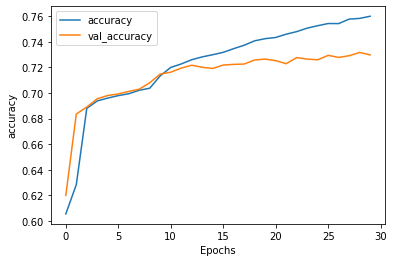

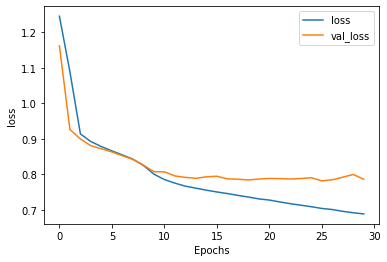

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, steps_per_epoch = 64*4, callbacks=[callback])

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

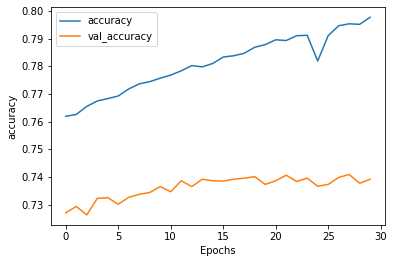

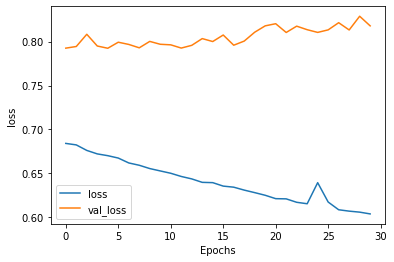

In [48]:
# history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, steps_per_epoch = 64*16, callbacks=[callback])

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           41472     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                15552     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 198       
Total params: 74,278
Trainable params: 74,278
Non-trainable params: 0
_________________________________________________________________
Train on 57344 samples, validate on 7518 samples
Epoch 1/30
57344/57344 - 113s - loss: 1.2288 - accuracy: 0.6033 - 

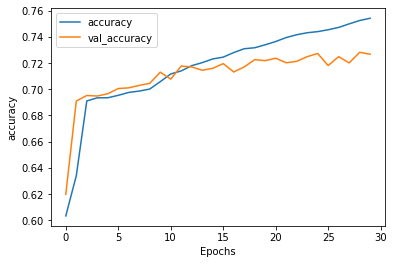

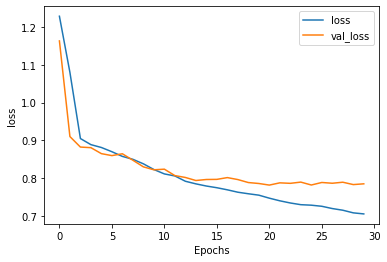

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, steps_per_epoch = 64*4, callbacks=[callback])

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [55]:
model.save('models/model_0.h5')